# Volume 3: Gibbs Sampling and LDA
    Jane Slagle
    Vol 3 lab section 1
    2/6/23

In [1]:
import numpy as np
from math import sqrt
from scipy.special import gammaln
from scipy.stats import norm, invgamma
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde

## Problem 1

Implement a Gibbs sampler for the exam scores problem (using the data in `examscores.npy`).
Test your sampler with priors $\nu=80$, $\tau^{2} = 16$, $\alpha = 3$, and $\beta = 50$, collecting $1000$ samples.
Plot your samples of $\mu$ and your samples of $\sigma^{2}$.

In [2]:
def gibbs(y, nu, tau2, alpha, beta, n_samples):
    """ Gibbs sampler for the exam scores problem, assuming the
    following likelihood and priors.
        y_i    ~ N(mu, sigma2),
        mu     ~ N(nu, tau2),
        sigma2 ~ IG(alpha, beta),

    Parameters:
        y ((N,) ndarray): the exam scores.
        nu (float): The prior mean parameter for mu.
        tau2 (float > 0): The prior variance parameter for mu.
        alpha (float > 0): The prior alpha parameter for sigma2.
        beta (float < 0): The prior beta parameter for sigma2.
        n_samples (int): the number of samples to draw.

    Returns:
        ((n_samples, 2) ndarray): The mu and sigma2 samples (as columns).
    """
    #get mean, variance using distributions they give in lab manual:
    mu = norm.rvs(nu, scale=sqrt(tau2))
    sig_2 = invgamma.rvs(alpha, scale=beta)
    
    #loop through num of samples and get new sig_squared, mu, alpha, beta values from starred eq. in lab manuals
    N = len(y)
    sum_y = sum(y)
    samps = []  #list to store all of the samples get in: goal here = have bunch of samples @ end
    for i in range(n_samples):
        sig_2_star = ((1/tau2) + (N/sig_2))**(-1)
        mu_star = sig_2_star*((nu/tau2) + ((1/sig_2)*sum_y))
        alpha_star = alpha + (N/2)
        beta_star = beta + (1/2)*sum([(y[i] - mu)**2 for i in range(N)])
        
        #get new mu, new sigma by plugging the new star values back into our distributions
        mu = norm.rvs(mu_star, scale = sqrt(sig_2_star))
        sig_2 = invgamma.rvs(alpha_star, scale=beta_star)
        
        #add these new mu, sig into our samples:
        samps.append((mu, sig_2))
        
    return samps

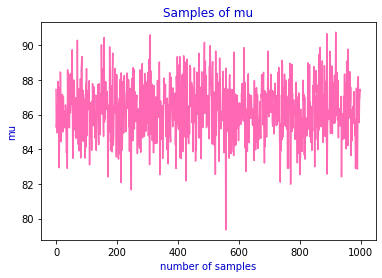

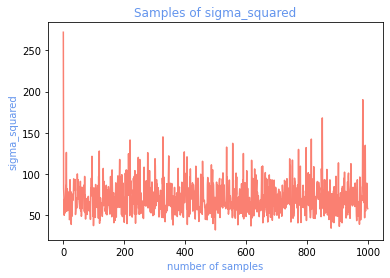

In [3]:
#test that ting now!
y = np.load("examscores.npy")  #want do it for the exam scores problem
nu = 80
tau2 = 16
alpha = 3
beta = 50
n_samples = 1000

samples = gibbs(y, nu, tau2, alpha, beta, n_samples)
samples = np.array(samples)    #turn it into array so that can plot it!

plt.title("Samples of mu", color = "mediumblue")
plt.xlabel("number of samples", color = "mediumblue")
plt.ylabel("mu", color = "mediumblue")
plt.plot(samples[:, 0], color = "hotpink")  #mu is 1st thing in samples, samples are returned as samples
plt.show()

plt.title("Samples of sigma_squared", color = "cornflowerblue")
plt.xlabel("number of samples", color = "cornflowerblue")
plt.ylabel("sigma_squared", color = "cornflowerblue")
plt.plot(samples[:, 1],color = "salmon")    #sigma_2 is 2nd thing in samples
plt.show()

## Problem 2

Plot the kernel density estimators for the posterior distributions of $\mu$ and $\sigma^2$.

Next, use your samples of $\mu$ and $\sigma^2$ to draw samples from the posterior predictive distribution.
Plot the kernel density estimator of your sampled scores.

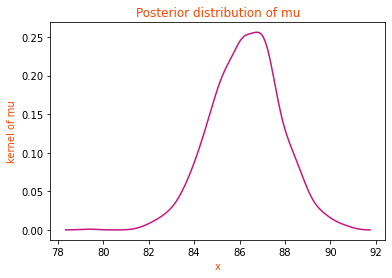

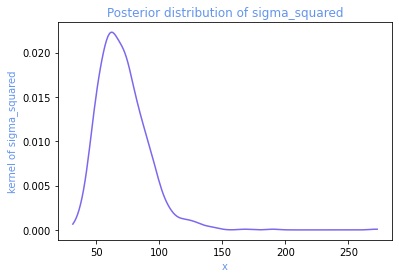

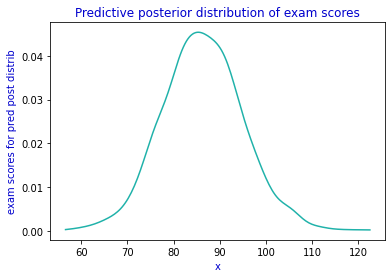

In [4]:
#get mu, sig_2 for posterior distributions:
mu_samples = samples[:, 0]
sig_samples = samples[:, 1]

#plot kde for mu_post, sig_post:
mu_kernel = gaussian_kde(mu_samples)
x = np.linspace(min(mu_samples) - 1, max(mu_samples) + 1, 200)
plt.title("Posterior distribution of mu", color = "orangered")
plt.xlabel("x", color = "orangered")
plt.ylabel("kernel of mu", color = "orangered")
plt.plot(x, mu_kernel(x), color = "mediumvioletred")
plt.show()

sig_kernel = gaussian_kde(sig_samples)
x2 = np.linspace(min(sig_samples) - 1, max(sig_samples) + 1, 200)
plt.title("Posterior distribution of sigma_squared", color = "cornflowerblue")
plt.xlabel("x", color = "cornflowerblue")
plt.ylabel("kernel of sigma_squared", color = "cornflowerblue")
plt.plot(x2, sig_kernel(x2), color = "mediumslateblue")
plt.show()

#use samples of mu, sig_2 to draw samples from posterior predictive distrib.
y_tilda = norm.rvs(mu_samples, scale = [sqrt(s) for s in sig_samples])  #this is y_tilda eq. in lab manual
post_pred_kernel = gaussian_kde(y_tilda)
x3 = np.linspace(min(y_tilda) - 1, max(y_tilda) + 1, 200)
plt.title("Predictive posterior distribution of exam scores", color = "mediumblue")
plt.xlabel("x", color = "mediumblue")
plt.ylabel("exam scores for pred post distrib", color = "mediumblue")
plt.plot(x3, post_pred_kernel(x3), color = "lightseagreen")
plt.show()

## Problem 3

Complete the method `LDACGS.initialize()`.



## Problem 4

Complete the method `LDACGS._sweep()`.



## Problem 5

Complete the method `LDACGS.sample()`.


In [10]:
class LDACGS:
    """ Do LDA with Gibbs Sampling. """

    def __init__(self, n_topics, alpha=0.1, beta=0.1):
        """ Initializes attributes n_topics, alpha, and beta. """
        self.n_topics = n_topics
        self.alpha = alpha
        self.beta = beta

    def buildCorpus(self, filename, stopwords_file=None):
        """ Reads the given filename, and using any provided stopwords,
            initializes attributes vocab and documents. 
            
            Vocab is a list of terms found in filename.
            
            Documents is a list of dictionaries (a dictionary for each 
            document); for dictionary m in documents, each entry is of 
            the form n:w, where w is the index in vocab of the nth word 
            in document m.
        """
        with open(filename, 'r') as infile:  # create vocab
            doclines = [line.rstrip().lower().split(' ') for line in infile]
        n_docs = len(doclines)
        self.vocab = list({v for doc in doclines for v in doc})
        
        if stopwords_file:   # if there are stopwords, remove them from vocab
            with open(stopwords_file, 'r') as stopfile:
                stops = stopfile.read().split()
            self.vocab = [x for x in self.vocab if x not in stops]
            self.vocab.sort()
        
        self.documents = []  # create documents
        for i in range(n_docs):
            self.documents.append({})
            for j in range(len(doclines[i])):
                if doclines[i][j] in self.vocab:
                    self.documents[i][j] = self.vocab.index(doclines[i][j])

                    
    def initialize(self):
        """ Initializes attributes n_words, n_docs, the three count matrices, 
            and topics.
                        
            Note that
            n_topics = K, the number of possible topics
            n_docs   = M, the number of documents being analyzed
            n_words  = V, the number of words in the vocabulary
            
            To do this, you will need to initialize nkm, nkv, and nk 
            to be zero arrays of the correct size.
            Matrix nkm corresponds to n_(k,m,.)
            Matrix nkv corresponds to n_(k,.,v)
            Matrix nk corresponds to n_(k,.,.)
            You will then iterate through each word found in each document.
            In the second of these for-loops (for each word), you will 
            randomly assign z as an integer from the range of topics.
            Then, you will increment each of the count matrices by 1, 
            given the values for z, m, and w, where w is the index in 
            vocab of the nth word in document m.
            Finally, assign topics as given.
        """
        self.n_words = len(self.vocab)
        self.n_docs = len(self.documents)
        
        # Initialize the three count matrices.
        # The (k, m) entry of self.nkm is the number of words in document m assigned to topic k.
        self.nkm = np.zeros((self.n_topics, self.n_docs))
        # The (k, v) entry of self.nkv is the number of times term v is assigned to topic k.
        self.nkv = np.zeros((self.n_topics, self.n_words))
        # The (k)-th entry of self.nk is the number of times topic k is assigned in the corpus.
        self.nk = np.zeros(self.n_topics)
        
        # Initialize the topic assignment dictionary.
        self.topics = {} # key-value pairs of form (m,i):z
        
        random_distribution = np.ones(self.n_topics) / self.n_topics
        for m in range(self.n_docs):
            for i in self.documents[m]:
                #PROB 3 - doing what is described in the 3 cols below:
                #m is whatever num doc we're on
                #look at this target + this doc so doc will address that topic
                #i = specific doc, look thru each word
                
                # (prob 3-1) Get random topic assignment, i.e. z = ...
                #n_topics is attribute here, want random topic assignment so randomly choose from it
                z = np.random.randint(self.n_topics) 
                
                # (prob 3-2) Increment count matrices
                #w = access dict to see how many times word pops up, increment by that word
                w = self.documents[m][i] #want increment by docs in nkm matrix, so have actually get docs 1st
                self.nkm[z, m] += 1           #nkm = increment topic + docs
                self.nkv[z, w] += 1           #mkv = increment topic + words
                self.nk[z] += 1               #nk = increment topic
                
                # (prob 3-3) Store topic assignment
                self.topics[(m, i)] = z           
                
    def _sweep(self):
        """ Iterates through each word of each document, giving a better
            topic assignment for each word.
            
            To do this, iterate through each word of each document. 
            The first part of this method will undo what initialize() did
            by decrementing each of the count matrices by 1.
            Then, call the method _conditional() to use the conditional 
            distribution (instead of the uniform distribution used 
            previously) to pick a more accurate topic assignment z.
            Finally, repeat what initialize() did by incrementing each of
            the count matrices by 1, but this time using the more 
            accurate topic assignment.
        """
        for m in range(self.n_docs):
            for i in self.documents[m]:
                #PROB 4: do all of these comments:
                
                # (prob 4 - 1) Retrieve vocab index for i-th word in document m.
                w = self.documents[m][i]  #this is vocab index, just like prob 3
                
                # (prob 4 - 2) Retrieve topic assignment for i-th word in document m.
                topic = self.topics[(m, i)]  #same exact as in prob 3
                
                # (prob 4 - 3) Decrement count matrices.
                #same as above but do -= 1 and use topic instead of z
                self.nkm[topic, m] -= 1           
                self.nkv[topic, w] -= 1        
                self.nk[topic] -= 1 
                
                # (prob 4 - 4) Get conditional distribution.
                condt_dist = self._conditional(m, w)
           
                # (prob 4 - 5) Sample new topic assignment.
                #get new topic, call it z like in prob 3
                #have n_topics below bc dont want num bigger than list of topics and p is for the distrib
                z = np.random.choice(range(self.n_topics), p=condt_dist)
                
                # (prob 4 - 6) Increment count matrices.
                #this is same exact as prob 3, with z, everything
                self.nkm[z, m] += 1           
                self.nkv[z, w] += 1          
                self.nk[z] += 1 
                
                # Store new topic assignment.
                #same exact as how saved it in prob 3
                self.topics[(m, i)] = z 
            
    def sample(self, filename, burnin=100, sample_rate=10, n_samples=10, stopwords_file=None):
        """ Runs the Gibbs sampler on the given filename. 
        
            The argument filename is the name and location of a .txt 
            file, where each line is considered a document.
            The corpus is built by method buildCorpus(), and 
            stopwords are removed (if argument stopwords is provided).
            
            Initialize attributes total_nkm, total_nkv, and logprobs as
            zero arrays.
            total_nkm and total_nkv will be the sums of every 
            sample_rate-th nkm and nkv matrix respectively.
            logprobs is of length burnin + sample_rate * n_samples
            and will store each log-likelihood after each sweep of 
            the sampler.
            
            Burn-in the Gibbs sampler.
            
            After the burn-in, iterate further for n_samples iterations, 
            adding nkm and nkv to total_nkm and total_nkv respectively, 
            but only for every sample_rate-th iteration.
            
            Also, compute and save the log-likelihood at each iteration 
            in logprobs using the method _loglikelihood().
        """
        self.buildCorpus(filename, stopwords_file)
        self.initialize()
        
        self.total_nkm = np.zeros((self.n_topics, self.n_docs))
        self.total_nkv = np.zeros((self.n_topics, self.n_words))
        self.logprobs = np.zeros(burnin + sample_rate * n_samples)
        
        for i in range(burnin):
            # Sweep and store log likelihood.
            self._sweep()   #call sweep method
            
            #told to compute, save log_likelihood @ each iteration in logprobs using method _loglikelihood()
            self.logprobs[i] = self._loglikelihood() 
            
        for i in range(sample_rate * n_samples):
            # Sweep and store log likelihood
            
            #exact same as above for loop except have to add burnin now bc after burn in 
            self._sweep()
            self.logprobs[i + burnin] = self._loglikelihood()
            
            if not i % sample_rate:
                # accumulate counts
                self.total_nkm += self.nkm
                self.total_nkv += self.nkv

    def _conditional(self, m, w):
        """ Returns the conditional distribution given m and w.
            Called by _sweep(). """
        dist = (self.nkm[:,m] + self.alpha) * (self.nkv[:,w] + self.beta) / (self.nk + self.beta * self.n_words)
        return dist / np.sum(dist)

    def _loglikelihood(self):
        """ Computes and returns the log-likelihood. Called by sample(). """
        lik = 0

        for z in range(self.n_topics):
            lik += np.sum(gammaln(self.nkv[z,:] + self.beta)) - gammaln(np.sum(self.nkv[z,:] + self.beta))
            lik -= self.n_words * gammaln(self.beta) - gammaln(self.n_words * self.beta)

        for m in range(self.n_docs):
            lik += np.sum(gammaln(self.nkm[:,m] + self.alpha)) - gammaln(np.sum(self.nkm[:,m] + self.alpha))
            lik -= self.n_topics * gammaln(self.alpha) - gammaln(self.n_topics * self.alpha)

        return lik
    
    def phi(self):
        """ Initializes attribute _phi. Called by topterms(). """
        phi = self.total_nkv + self.beta
        self._phi = phi / np.sum(phi, axis=1)[:,np.newaxis]

    def theta(self):
        """ Initializes attribute _theta. Called by topterms. """
        theta = self.total_nkm + self.alpha
        self._theta = theta / np.sum(theta, axis=1)[:,np.newaxis]

    def topterms(self, n_terms=10):
        """ Returns the top n_terms of each topic found. """
        self.phi()
        self.theta()
        vec = np.atleast_2d(np.arange(0, self.n_words))
        topics = []
        for k in range(self.n_topics):
            probs = np.atleast_2d(self._phi[k,:])
            mat = np.append(probs, vec, 0)
            sind = np.array([mat[:,i] for i in np.argsort(mat[0])]).T
            topics.append([self.vocab[int(sind[1, self.n_words - 1 - i])] for i in range(n_terms)])
        return topics

## Problem 6

Create an `LDACGS` object with $20$ topics, letting $\alpha$ and $\beta$ be the default values.
Run the Gibbs sampler, with a burn in of $100$ iterations, accumulating $10$ samples, only keeping the results of every $10$th sweep.
Use `stopwords.txt` as the stopwords file.

Plot the log-likelihoods. How many iterations did it take to burn-in?

In [11]:
LDA = LDACGS(20)  #create LDACGS object with 20 objects, have alpha and beta be default values

#want do it on reagan.txt file: so sample from reagan.txt w/ stopwords.txt as stopwords file
LDA.sample('reagan.txt', stopwords_file = 'stopwords.txt')

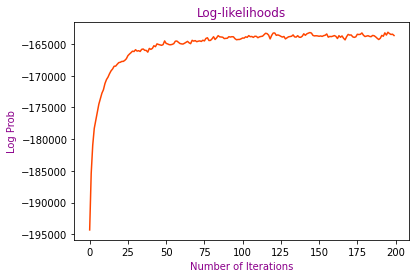

In [14]:
#plot log-likelihoods
plt.plot(LDA.logprobs, color = "orangered")
plt.title("Log-likelihoods", color = "darkmagenta")
plt.xlabel("Number of Iterations", color = "darkmagenta")
plt.ylabel("Log Prob", color = "darkmagenta")
plt.show()

## Problem 7

Using the method `LDACGS.topterms()`, examine the topics for Reagan's addresses. 
If `n_topics=20` and `n_samples=10`, you should get the top $10$ words that represent each of the $20$ topics.
For each topic, decide what these ten words jointly represent, and come up with a label for them.

In [38]:
#look at top terms:
top_terms = LDA.topterms()

In [39]:
#get the 20 labels for each of the 20 topics, can print out top_terms and see the gist of each topic have:
#look at the labels and just make those suckers up!
labels = ['government', 'politics', 'past', 'citizens', 'taxes', 'families', 'religion', 'moolah', 'depression',
         'sections', 'violence', 'security', 'public', 'americans', 'business', 'futures', 'economics',
         'freedom', 'laws', 'presidents']

In [41]:
for i in range(len(top_terms)):
    print(labels[i], " is ", "the label for terms: ", top_terms[i])

government  is  the label for terms:  ['federal', 'billion', 'spending', 'government', 'budget', 'programs', 'growth', 'national', '--', 'reduce']
politics  is  the label for terms:  ['mr.', 'freedom', 'speaker,', 'congress,', 'democratic', 'members', 'democracy', 'president,', 'people', 'distinguished']
past  is  the label for terms:  ['years', 'young', 'ago,', 'americans', 'ago', 'problems', 'living', 'high', 'future.', 'year']
citizens  is  the label for terms:  ['jobs', 'private', 'work', 'people', 'million', 'program', 'job', 'continue', 'space', 'sector']
taxes  is  the label for terms:  ['tax', 'interest', 'economic', 'inflation', 'rates', 'rate', 'government', 'percent', 'increase', 'reduction']
families  is  the label for terms:  ['children', 'child', 'family', 'life', 'families', 'human', 'school', 'back', 'parents', 'education']
religion  is  the label for terms:  ['god', 'people', 'you,', 'bless', 'america.', 'you.', "it's", "don't", 'people.', 'well,']
moolah  is  the labe